In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Data

In [2]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_lenscolor_source/mb_lenscolor_source.npy'
target_img_path = head / 'data/mb_lenscolor_target/mb_lenscolor_target.npy'
source_meta = head / 'data/mb_lenscolor_source/mb_lenscolor_source_metadata.csv'
target_meta = head / 'data/mb_lenscolor_target/mb_lenscolor_target_metadata.csv'
batch_size = 256
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

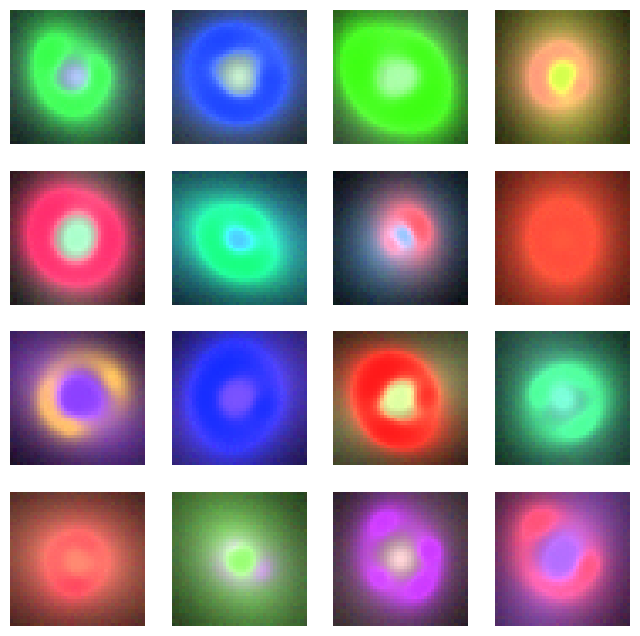

In [3]:
# Visualize source data
visualize_data(source_data)

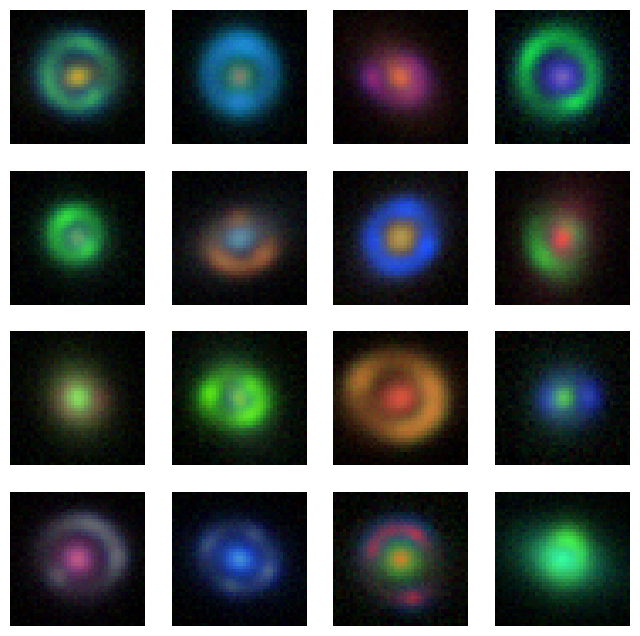

In [4]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [5]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return da_weight

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (epoch / n_epoch)
    return beta_val

# Initialize hyperparameters
learning_rate = 3e-5
n_epoch = 150
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.4

In [6]:
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/mve_v6_b256_aug4_0005"

## Train

Beginning Training...
Generating Isomap...


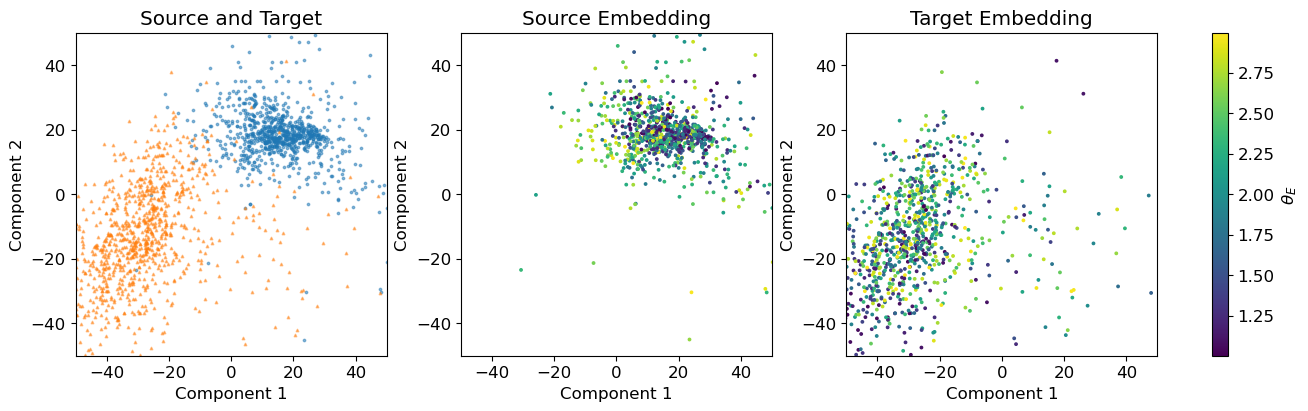


Epoch 0: 14.13s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4039
	Train Regression Loss: : 3.3785
	Train Mve Loss: : 1.5452
	Train R2 Score: : -9.1758
 Validation Statistics:
	Val Source Regression Loss: : 2.8053
	Val Target Regression Loss: : 2.7978
	Val Source R2 Score: : -7.3712
	Val Target R2 Score: : -7.5757
	Val Source Mve Loss: : 1.2352
	Val Target Mve Loss: : 1.2299
Saving Model MVE... Done.

Epoch 1: 12.52s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3210
	Train Regression Loss: : 2.1979
	Train Mve Loss: : 0.9391
	Train R2 Score: : -5.6213
 Validation Statistics:
	Val Source Regression Loss: : 1.7517
	Val Target Regression Loss: : 1.7342
	Val Source R2 Score: : -4.2605
	Val Target R2 Score: : -4.2872
	Val Source Mve Loss: : 0.7195
	Val Target Mve Loss: : 0.7076
Saving Model MVE... Done.

Epoch 2: 12.39s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2603
	Train Regression Loss: : 1.3367
	Tr

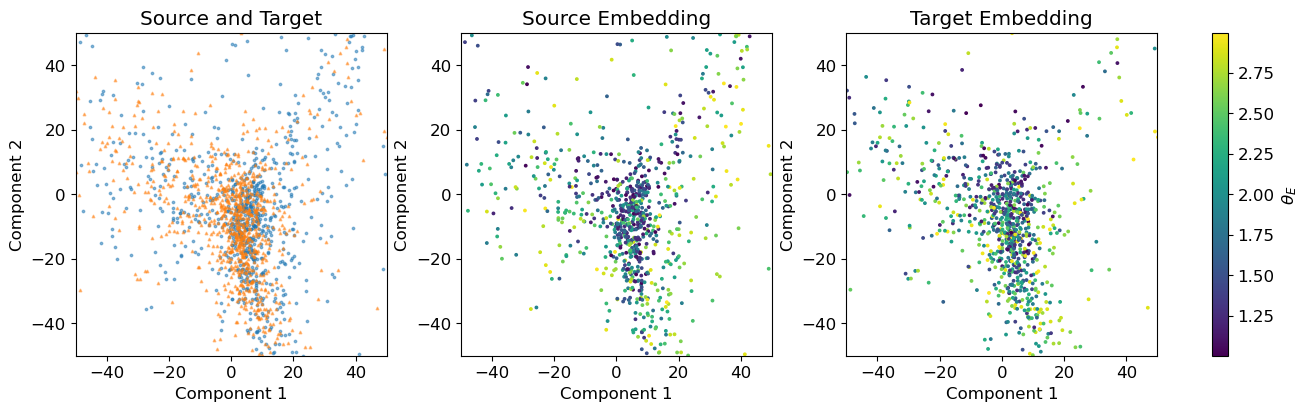

Saving Model... Done.
Saving Model MVE... Done.

Epoch 20: 12.78s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0389
	Train Regression Loss: : 0.0880
	Train Mve Loss: : -0.0966
	Train R2 Score: : 0.7352
 Validation Statistics:
	Val Source Regression Loss: : 0.0869
	Val Target Regression Loss: : 0.0928
	Val Source R2 Score: : 0.7401
	Val Target R2 Score: : 0.7177
	Val Source Mve Loss: : -0.0942
	Val Target Mve Loss: : -0.0915
Saving Model... Done.
Saving Model MVE... Done.

Epoch 21: 12.53s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0378
	Train Regression Loss: : 0.0780
	Train Mve Loss: : -0.0831
	Train R2 Score: : 0.7654
 Validation Statistics:
	Val Source Regression Loss: : 0.0780
	Val Target Regression Loss: : 0.0828
	Val Source R2 Score: : 0.7671
	Val Target R2 Score: : 0.7486
	Val Source Mve Loss: : -0.0748
	Val Target Mve Loss: : -0.0736
Saving Model... Done.

Epoch 22: 12.69s
-------------------------------
 Training Stat

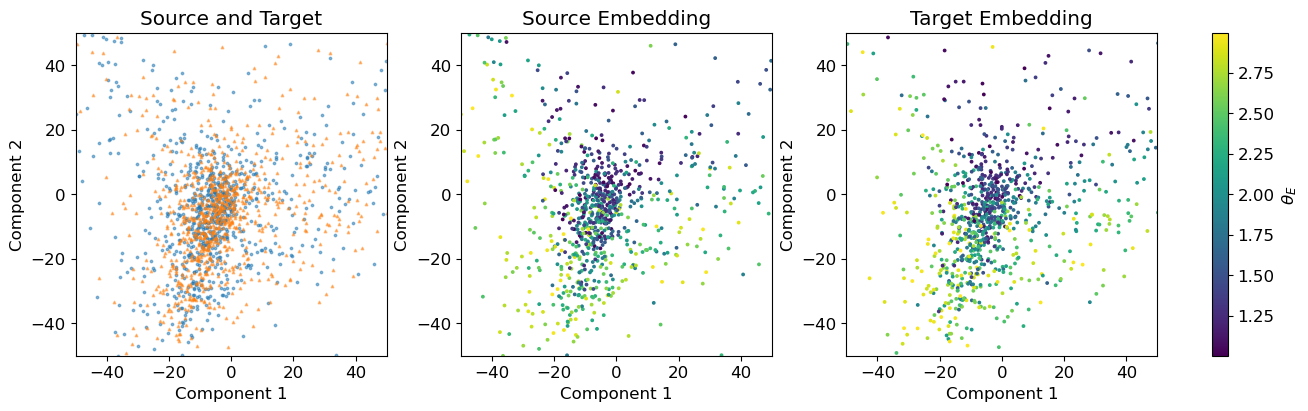

Saving Model... Done.

Epoch 40: 13.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0255
	Train Regression Loss: : 0.0296
	Train Mve Loss: : -0.0898
	Train R2 Score: : 0.9108
 Validation Statistics:
	Val Source Regression Loss: : 0.0311
	Val Target Regression Loss: : 0.0348
	Val Source R2 Score: : 0.9067
	Val Target R2 Score: : 0.8943
	Val Source Mve Loss: : -0.1293
	Val Target Mve Loss: : -0.1283
Saving Model... Done.

Epoch 41: 13.29s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0242
	Train Regression Loss: : 0.0290
	Train Mve Loss: : -0.0886
	Train R2 Score: : 0.9127
 Validation Statistics:
	Val Source Regression Loss: : 0.0306
	Val Target Regression Loss: : 0.0346
	Val Source R2 Score: : 0.9084
	Val Target R2 Score: : 0.8944
	Val Source Mve Loss: : -0.1340
	Val Target Mve Loss: : -0.1333
Saving Model... Done.

Epoch 42: 12.71s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0248
	Train Regression L

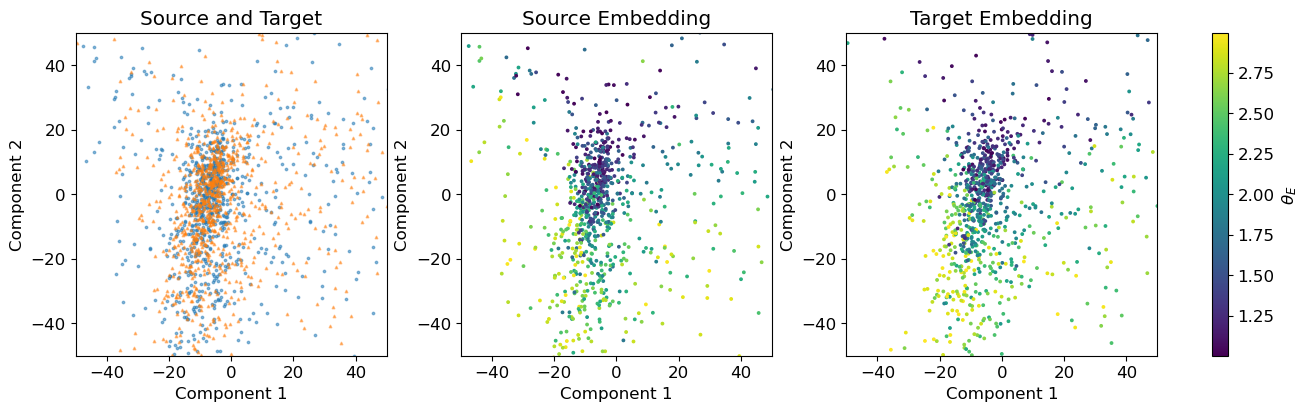

Saving Model... Done.

Epoch 60: 12.65s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0212
	Train Regression Loss: : 0.0208
	Train Mve Loss: : -0.0984
	Train R2 Score: : 0.9375
 Validation Statistics:
	Val Source Regression Loss: : 0.0218
	Val Target Regression Loss: : 0.0249
	Val Source R2 Score: : 0.9347
	Val Target R2 Score: : 0.9244
	Val Source Mve Loss: : -0.1277
	Val Target Mve Loss: : -0.1240
Saving Model... Done.

Epoch 61: 12.82s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0216
	Train Regression Loss: : 0.0205
	Train Mve Loss: : -0.1297
	Train R2 Score: : 0.9382
 Validation Statistics:
	Val Source Regression Loss: : 0.0214
	Val Target Regression Loss: : 0.0245
	Val Source R2 Score: : 0.9360
	Val Target R2 Score: : 0.9256
	Val Source Mve Loss: : -0.1601
	Val Target Mve Loss: : -0.1565
Saving Model... Done.

Epoch 62: 12.88s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0215
	Train Regression L

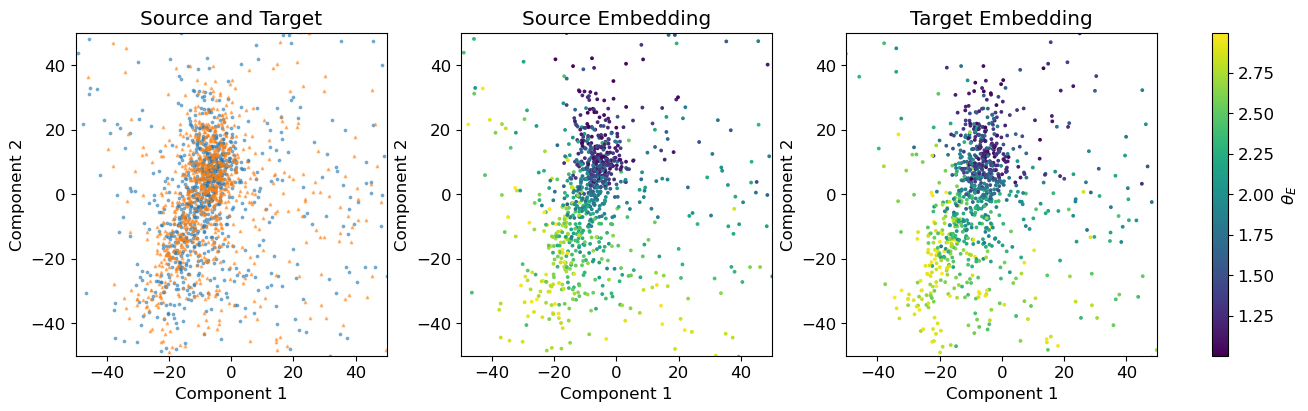

Saving Model MVE... Done.

Epoch 80: 13.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0196
	Train Regression Loss: : 0.0169
	Train Mve Loss: : -0.1746
	Train R2 Score: : 0.9491
 Validation Statistics:
	Val Source Regression Loss: : 0.0184
	Val Target Regression Loss: : 0.0220
	Val Source R2 Score: : 0.9447
	Val Target R2 Score: : 0.9327
	Val Source Mve Loss: : -0.0733
	Val Target Mve Loss: : -0.0527

Epoch 81: 13.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0189
	Train Regression Loss: : 0.0169
	Train Mve Loss: : -0.1612
	Train R2 Score: : 0.9492
 Validation Statistics:
	Val Source Regression Loss: : 0.0183
	Val Target Regression Loss: : 0.0215
	Val Source R2 Score: : 0.9452
	Val Target R2 Score: : 0.9346
	Val Source Mve Loss: : -0.2195
	Val Target Mve Loss: : -0.2169

Epoch 82: 14.38s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0192
	Train Regression Loss: : 0.0166
	Train Mve Loss: : -0.1907

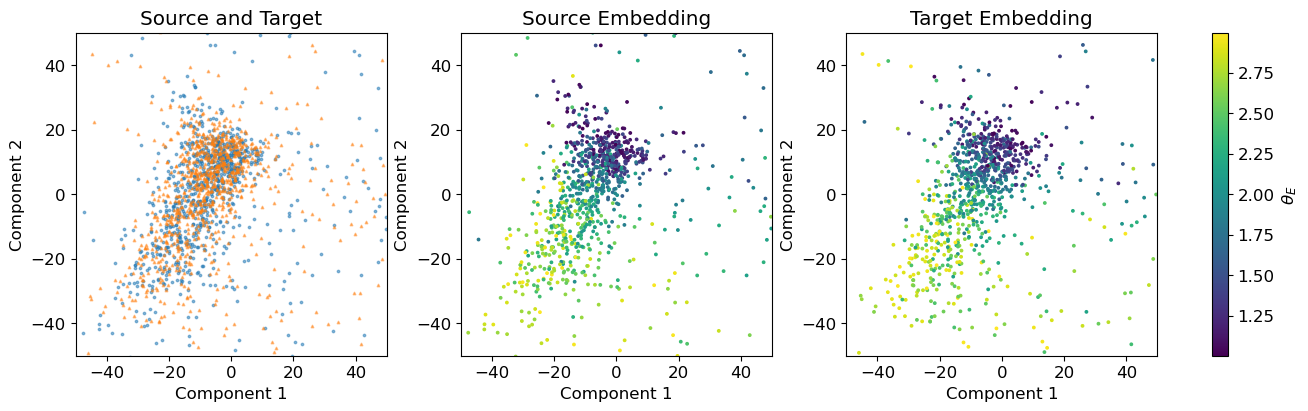


Epoch 100: 13.22s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0183
	Train Regression Loss: : 0.0152
	Train Mve Loss: : -0.1630
	Train R2 Score: : 0.9541
 Validation Statistics:
	Val Source Regression Loss: : 0.0165
	Val Target Regression Loss: : 0.0187
	Val Source R2 Score: : 0.9507
	Val Target R2 Score: : 0.9427
	Val Source Mve Loss: : -0.0859
	Val Target Mve Loss: : -0.0178

Epoch 101: 13.03s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0187
	Train Regression Loss: : 0.0156
	Train Mve Loss: : -0.2054
	Train R2 Score: : 0.9530
 Validation Statistics:
	Val Source Regression Loss: : 0.0162
	Val Target Regression Loss: : 0.0188
	Val Source R2 Score: : 0.9515
	Val Target R2 Score: : 0.9429
	Val Source Mve Loss: : -0.1649
	Val Target Mve Loss: : -0.1162
Saving Model... Done.

Epoch 102: 13.31s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0182
	Train Regression Loss: : 0.0150
	Train Mve Loss: : -0.1814


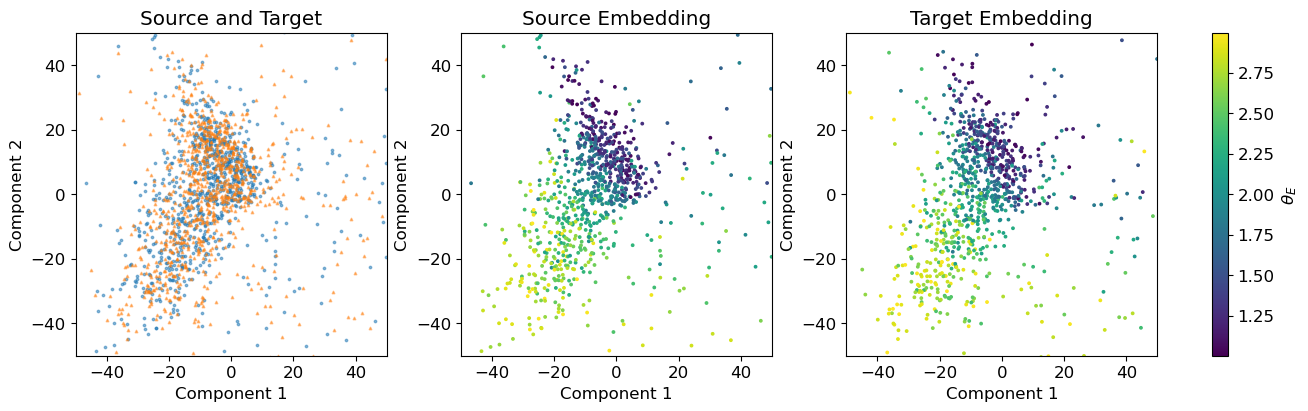

Saving Model... Done.

Epoch 120: 13.69s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0182
	Train Regression Loss: : 0.0145
	Train Mve Loss: : -0.1790
	Train R2 Score: : 0.9563
 Validation Statistics:
	Val Source Regression Loss: : 0.0162
	Val Target Regression Loss: : 0.0182
	Val Source R2 Score: : 0.9518
	Val Target R2 Score: : 0.9449
	Val Source Mve Loss: : -0.3054
	Val Target Mve Loss: : -0.3034

Epoch 121: 13.26s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0189
	Train Regression Loss: : 0.0145
	Train Mve Loss: : -0.3037
	Train R2 Score: : 0.9565
 Validation Statistics:
	Val Source Regression Loss: : 0.0155
	Val Target Regression Loss: : 0.0178
	Val Source R2 Score: : 0.9536
	Val Target R2 Score: : 0.9460
	Val Source Mve Loss: : -0.3165
	Val Target Mve Loss: : -0.3142
Saving Model MVE... Done.

Epoch 122: 13.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0184
	Train Regression Loss: : 0.0140
	

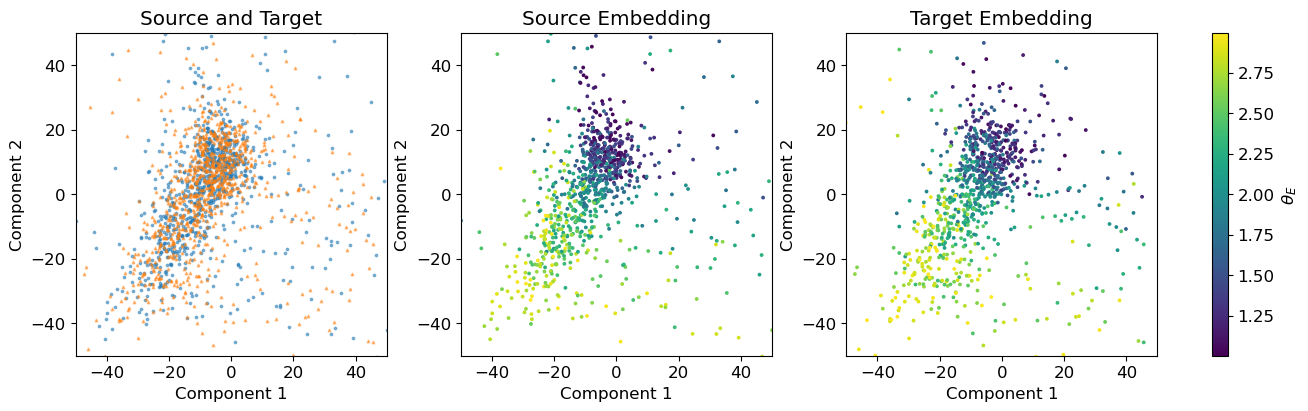


Epoch 140: 13.90s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0181
	Train Regression Loss: : 0.0143
	Train Mve Loss: : -0.2532
	Train R2 Score: : 0.9568
 Validation Statistics:
	Val Source Regression Loss: : 0.0152
	Val Target Regression Loss: : 0.0176
	Val Source R2 Score: : 0.9547
	Val Target R2 Score: : 0.9465
	Val Source Mve Loss: : -0.1155
	Val Target Mve Loss: : 0.0745

Epoch 141: 13.33s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0182
	Train Regression Loss: : 0.0144
	Train Mve Loss: : -0.1203
	Train R2 Score: : 0.9566
 Validation Statistics:
	Val Source Regression Loss: : 0.0156
	Val Target Regression Loss: : 0.0183
	Val Source R2 Score: : 0.9534
	Val Target R2 Score: : 0.9444
	Val Source Mve Loss: : 0.6415
	Val Target Mve Loss: : 0.8040

Epoch 142: 13.22s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0179
	Train Regression Loss: : 0.0145
	Train Mve Loss: : 0.0772
	Train R2 Score: : 0.9562


In [8]:
print("Beginning Training...")


for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1

        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [9]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [10]:
# Loads a model for plotting/viz

viz_mod_name = final_mod_name # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

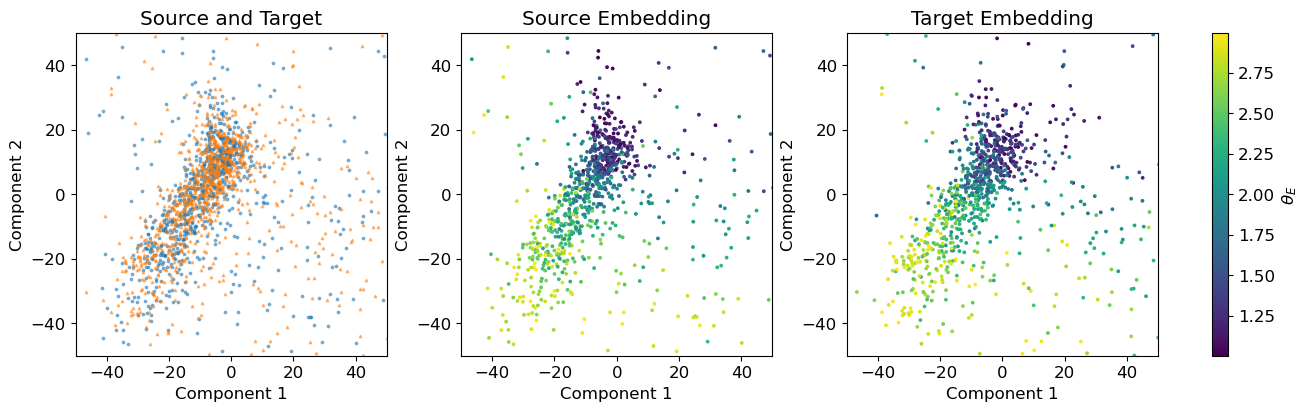

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [11]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

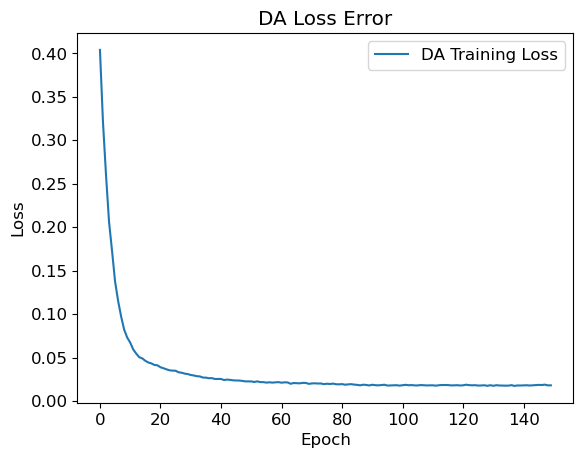

In [12]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

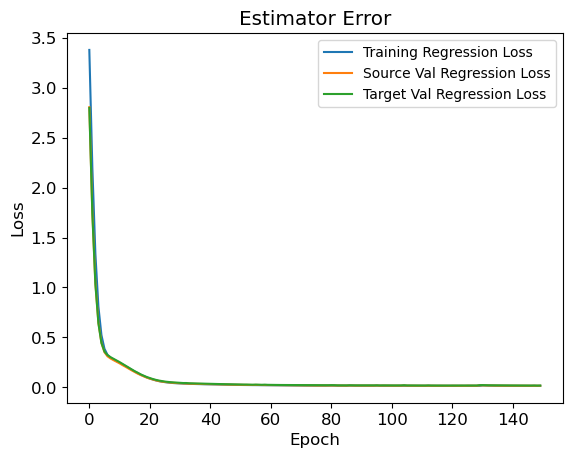

In [13]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

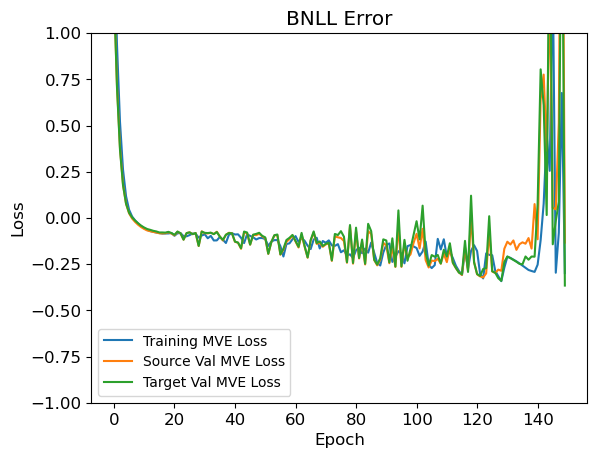

In [14]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

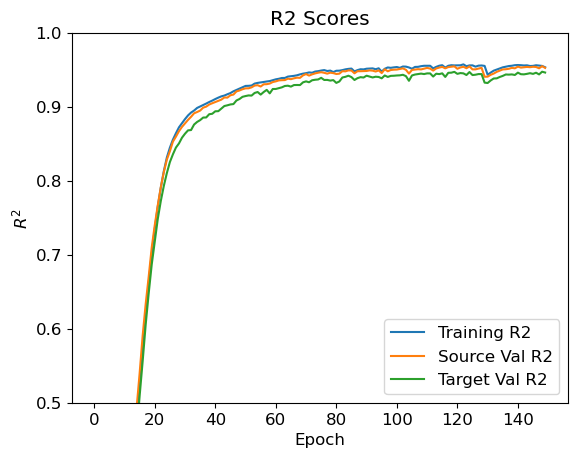

In [15]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [16]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9527


Text(0.5, 1.0, 'MMD | Source | R2: 0.953')

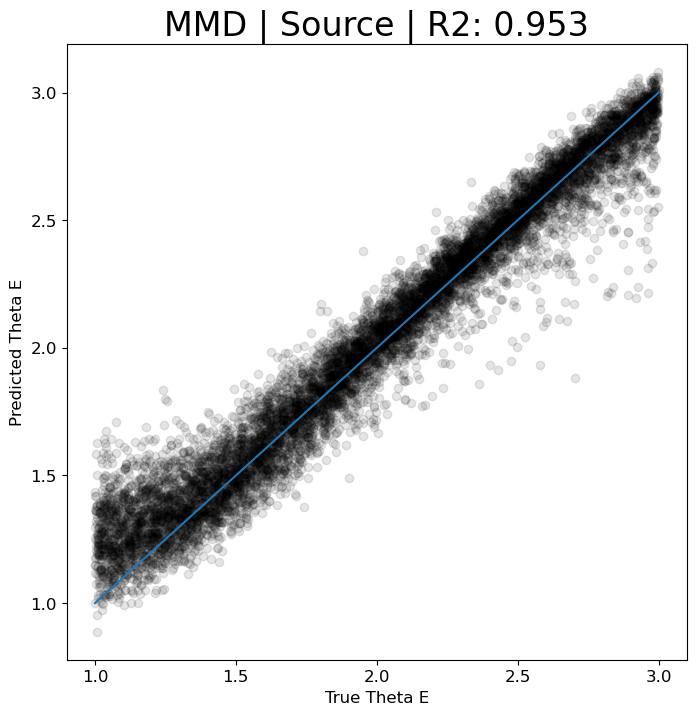

In [17]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.330')

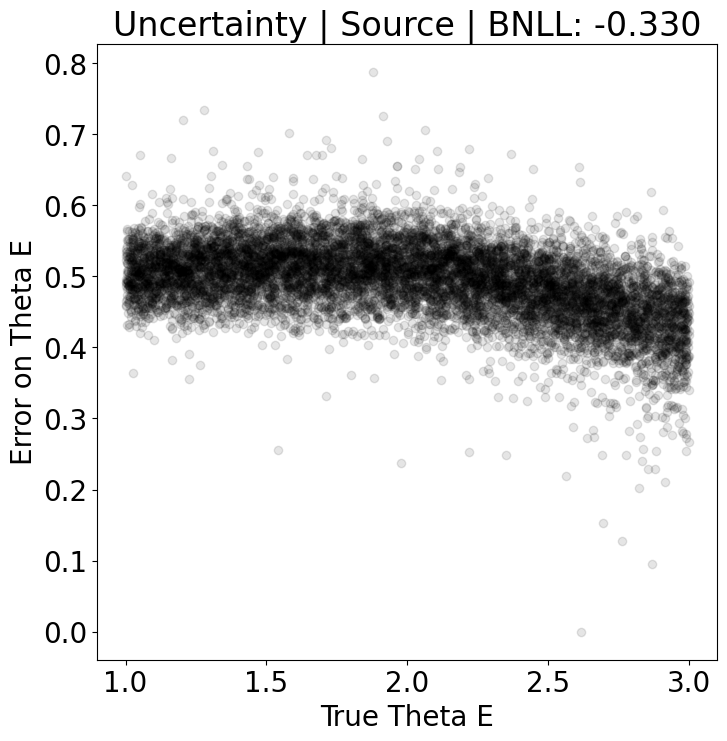

In [18]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [19]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9461


Text(0.5, 1.0, 'MMD | Target | R2: 0.946')

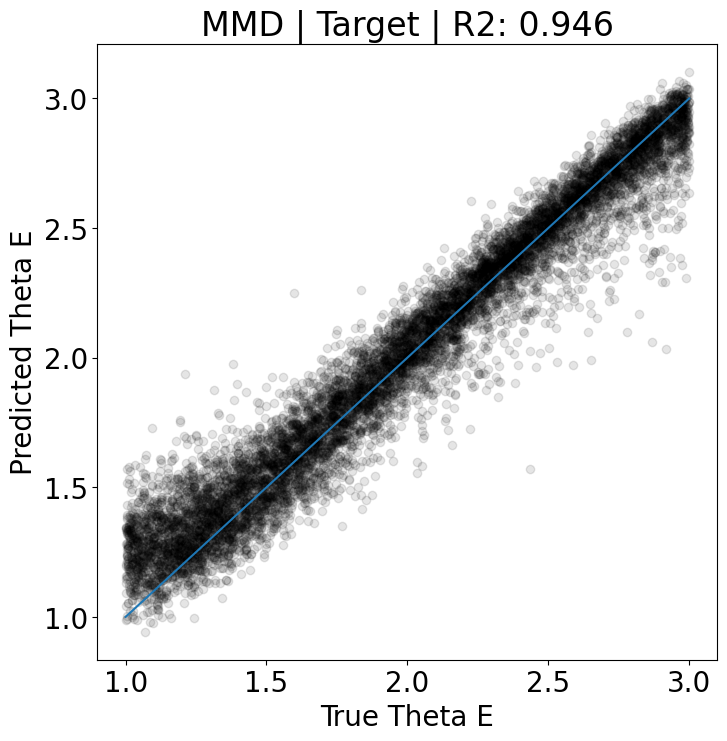

In [20]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.946')

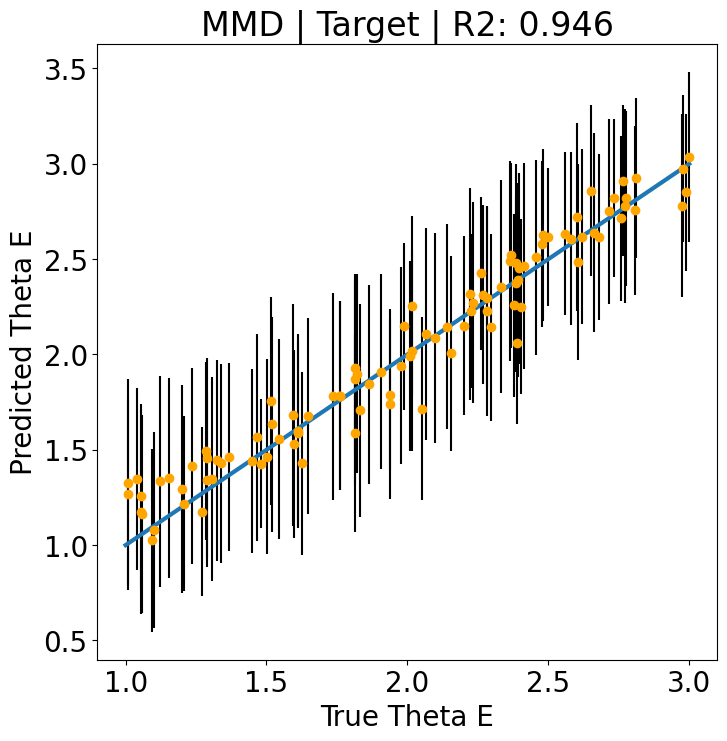

In [21]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.325')

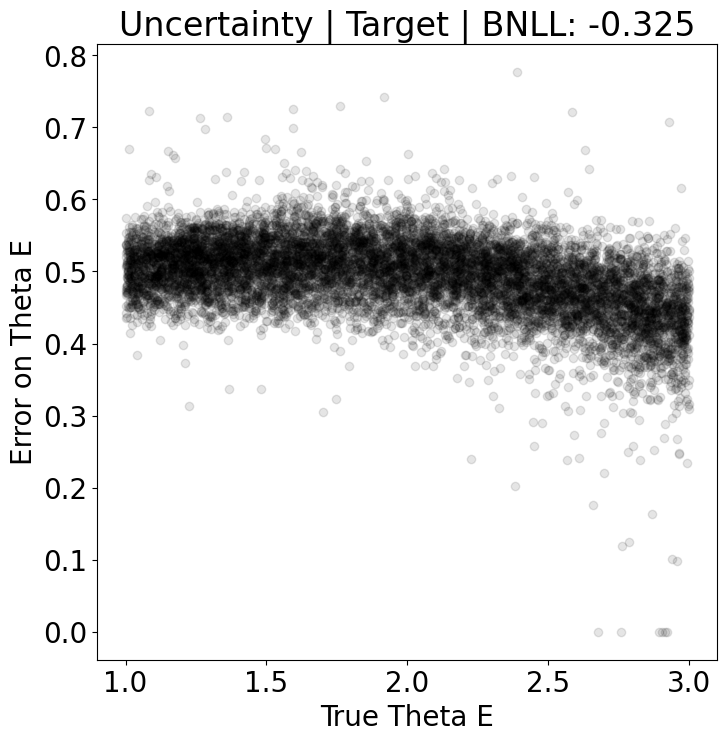

In [22]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [23]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

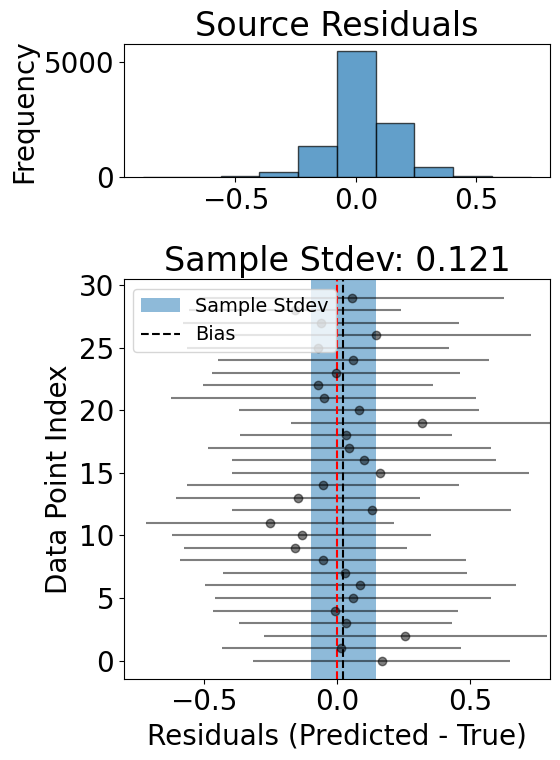

In [24]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

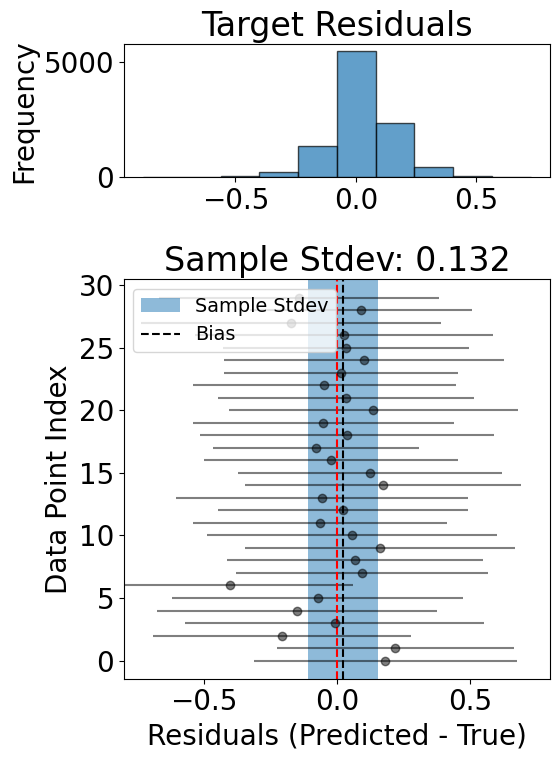

In [25]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()